<a href="https://colab.research.google.com/github/bipinKrishnan/ML_from_scratch/blob/master/FGSM_LeNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt

In [ ]:
bs = 128

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

trainloader = DataLoader(trainset, batch_size=bs, shuffle=True)
testloader = DataLoader(testset, batch_size=bs)

In [3]:
classes = list(range(10))
classes

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [ ]:
images, labels = next(iter(trainloader))

In [ ]:
images.size(0)

1, 9, 6, 1, 9, 6, 7, 4, 3, 7, 7, 5, 9, 0, 0, 8, 2, 1, 1, 6, 4, 7, 5, 8, 6, 2, 8, 8, 7, 6, 2, 5


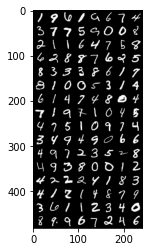

In [6]:
def imshow(img):
  img = img.numpy()
  img = np.transpose(img, (1, 2, 0))
  plt.imshow(img)

imshow(torchvision.utils.make_grid(images))
print(', '.join(str(classes[labels[i]]) for i in range(32)))

In [7]:
class Lenet(nn.Module):
  def __init__(self):
    super(Lenet, self).__init__()
    self.cnn_net = nn.Sequential(
        nn.Conv2d(1, 6, 5),
        nn.Tanh(),
        nn.AvgPool2d(2, stride=2),
        nn.Conv2d(6, 16, 5),
        nn.Tanh(),
        nn.AvgPool2d(2, stride=2)
    )

    self.fcn_net = nn.Sequential(
        nn.Linear(256, 120),
        nn.Tanh(),
        nn.Linear(120, 84),
        nn.Tanh(),
        nn.Linear(84, 10)
    )

  def forward(self, x):
    #print(inputs.shape)
    x = self.cnn_net(x)
    #print(x.shape)
    x = x.view(x.size(0), -1)
    #print(x.shape)
    out = self.fcn_net(x)

    return out

In [17]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = Lenet().to(device)

In [18]:
def evaluation(dataloader):
  total, correct = 0, 0

  for data in dataloader:
    inputs, labels = data
    outputs = net(inputs.to(device))

    _, pred = torch.max(outputs, 1)
    
    total += labels.size(0)
    correct += (pred == labels.to(device)).sum().item()

    return (correct/total * 100)

In [19]:
loss_fn = nn.CrossEntropyLoss()
opt = optim.Adam(net.parameters())

In [20]:
epochs = 10

for epoch in range(epochs):
  for data in trainloader:
    inputs, labels = data

    opt.zero_grad()

    outputs = net(inputs.to(device))
    loss = loss_fn(outputs, labels.to(device))
    
    loss.backward()
    opt.step()

  print('Epoch %d/%d \t Train acc: %0.2f \t Test acc: %0.2f' % (epoch+1, epochs, evaluation(trainloader), evaluation(testloader)))

Epoch 1/10 	 Train acc: 92.97 	 Test acc: 97.66
Epoch 2/10 	 Train acc: 97.66 	 Test acc: 100.00
Epoch 3/10 	 Train acc: 98.44 	 Test acc: 100.00
Epoch 4/10 	 Train acc: 99.22 	 Test acc: 100.00
Epoch 5/10 	 Train acc: 99.22 	 Test acc: 98.44
Epoch 6/10 	 Train acc: 99.22 	 Test acc: 100.00
Epoch 7/10 	 Train acc: 98.44 	 Test acc: 99.22
Epoch 8/10 	 Train acc: 100.00 	 Test acc: 98.44
Epoch 9/10 	 Train acc: 100.00 	 Test acc: 99.22
Epoch 10/10 	 Train acc: 100.00 	 Test acc: 99.22


## Attacking the net

In [67]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [92]:
net.eval()
adv_viz = []
adv_lab = []
orig = []
orig_lab = []

for data, label in testloader:
  data, label = data.to(device), label.to(device)

  data.requires_grad = True

  out = net(data)
  pred = out.max(1)[1]

  loss = loss_fn(out, label)

  net.zero_grad()
  loss.backward()

  data_grad = data.grad.data
  perturbed_img = fgsm_attack(data, 0.05, data_grad)

  out1 = net(perturbed_img)
  pred1 = out1.max(1)[1]

  adv_viz.append(perturbed_img)
  adv_lab.append(pred1)

  orig.append(data)
  orig_lab.append(pred)
  

  print(f'{pred}\n{pred1}\n{label}')
  break

tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5,
        4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2,
        4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3, 7, 4, 6, 4, 3, 0, 7, 0,
        2, 9, 1, 7, 3, 2, 9, 7, 7, 6, 2, 7, 8, 4, 7, 3, 6, 1, 3, 6, 9, 3, 1, 4,
        1, 7, 6, 9, 6, 0, 5, 4, 5, 9, 2, 1, 9, 4, 8, 7, 3, 9, 7, 4, 4, 4, 9, 2,
        5, 4, 7, 6, 7, 9, 0, 5], device='cuda:0')
tensor([7, 2, 8, 0, 9, 1, 8, 3, 5, 9, 0, 6, 4, 0, 1, 3, 9, 7, 8, 4, 7, 5, 6, 5,
        4, 0, 7, 4, 0, 3, 3, 8, 3, 4, 7, 2, 2, 1, 2, 1, 8, 2, 4, 6, 3, 5, 8, 2,
        4, 4, 6, 3, 5, 5, 6, 0, 4, 8, 9, 5, 7, 8, 5, 3, 7, 9, 6, 4, 3, 0, 7, 0,
        2, 9, 1, 7, 3, 2, 4, 7, 7, 6, 2, 7, 8, 4, 7, 3, 6, 1, 3, 6, 4, 3, 1, 4,
        9, 7, 6, 9, 6, 0, 5, 4, 5, 9, 2, 8, 9, 4, 8, 1, 3, 9, 7, 9, 4, 4, 9, 2,
        5, 4, 7, 6, 4, 4, 0, 5], device='cuda:0')
tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5,
        4, 0, 7, 4, 

Text(0.5, 1.0, 'Original Image - Prediction: 1')

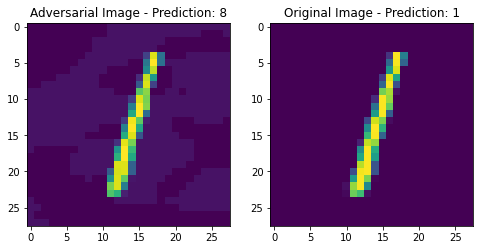

In [109]:
idx = 2

plt.figure(figsize=(8, 6))
plt.subplot(1, 2, 1)
plt.imshow(adv_viz[0][idx].detach().cpu().squeeze())
plt.title(f'Adversarial Image - Prediction: {adv_lab[0][idx].item()}')

plt.subplot(1, 2, 2)
plt.imshow(orig[0][idx].detach().cpu().squeeze())
plt.title(f'Original Image - Prediction: {orig_lab[0][idx].item()}')

In [101]:
adv_viz[0][idx].sum()

tensor(85.8765, device='cuda:0', grad_fn=<SumBackward0>)

In [102]:
orig[0][idx].sum()

tensor(72.3686, device='cuda:0', grad_fn=<SumBackward0>)